In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Data

In [2]:
import urllib.request  # the lib that handles the url stuff

data = urllib.request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names') # it's a file like object and works just like a file
for line in data: # files are iterable
    print(line)

b'1. Title: Auto-Mpg Data\n'
b'\n'
b'2. Sources:\n'
b'   (a) Origin:  This dataset was taken from the StatLib library which is\n'
b'                maintained at Carnegie Mellon University. The dataset was \n'
b'                used in the 1983 American Statistical Association Exposition.\n'
b'   (c) Date: July 7, 1993\n'
b'\n'
b'3. Past Usage:\n'
b'    -  See 2b (above)\n'
b'    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.\n'
b'       In Proceedings on the Tenth International Conference of Machine \n'
b'       Learning, 236-243, University of Massachusetts, Amherst. Morgan\n'
b'       Kaufmann.\n'
b'\n'
b'4. Relevant Information:\n'
b'\n'
b'   This dataset is a slightly modified version of the dataset provided in\n'
b'   the StatLib library.  In line with the use by Ross Quinlan (1993) in\n'
b'   predicting the attribute "mpg", 8 of the original instances were removed \n'
b'   because they had unknown values for the "mpg" attribute.  The original \n'
b'   d

In [3]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data', delim_whitespace=True, names=column_names)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


# Data cleaning

In [4]:
df = df.replace('?', np.nan)
df = df.dropna()
df['horsepower'] = df['horsepower'].astype(float)
df['origin'] = df['origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# Data visualisation

In [5]:
independant_var = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']

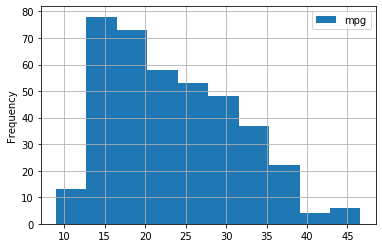

In [6]:
df.plot(kind='hist', y='mpg', grid=True)

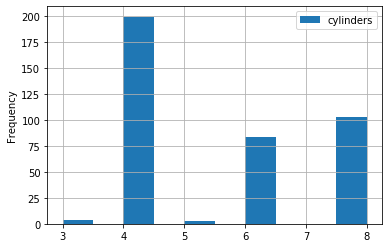

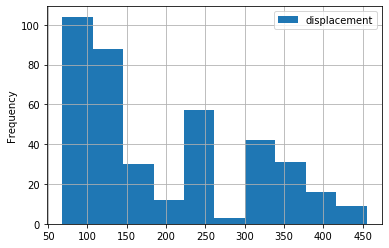

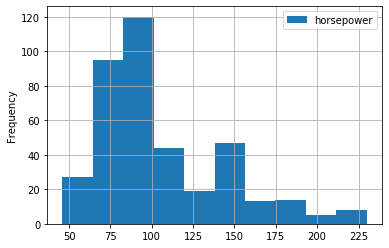

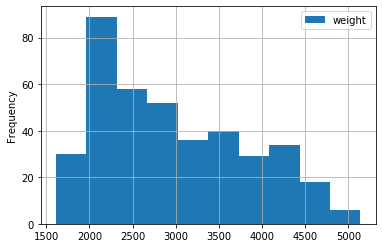

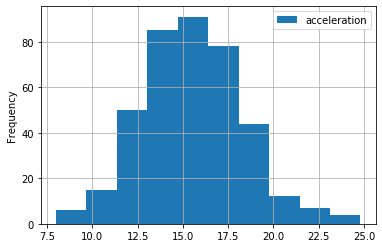

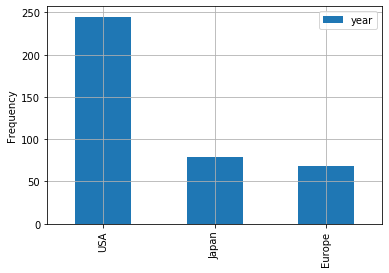

In [7]:
for param in independant_var:
    try:
        df.plot(kind='hist', y=param, grid=True)
    except:
        df[param].value_counts().plot(kind='bar', grid=True)

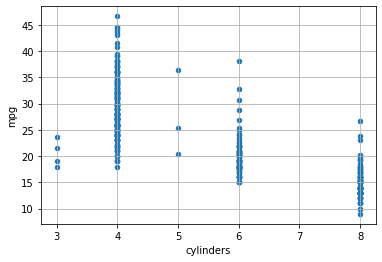

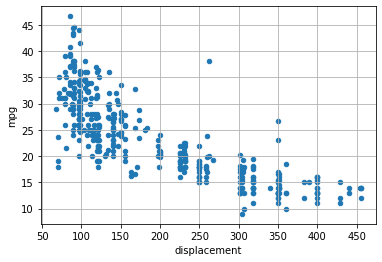

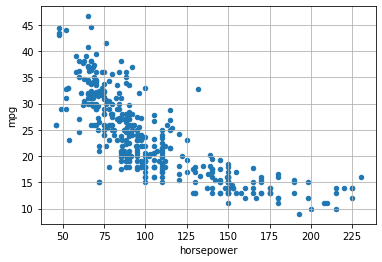

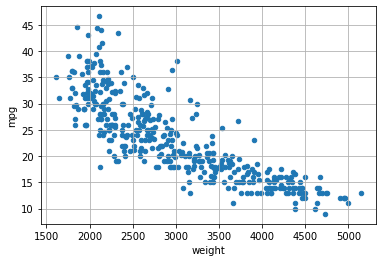

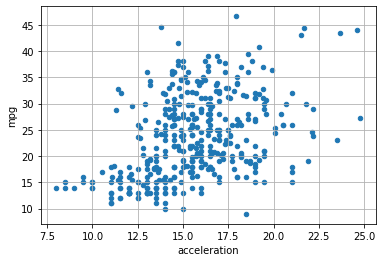

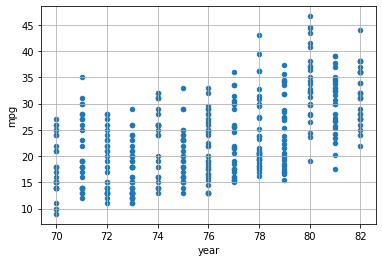

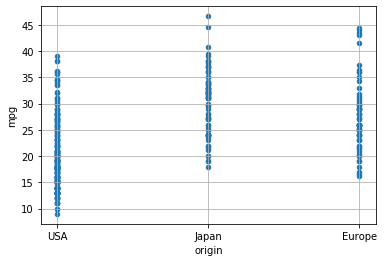

In [8]:
for param in independant_var:
    df.plot(kind='scatter', x=param, y='mpg', grid=True)

# Model
Aim is to model mpg (miles per gallon) from information contained in the dataset

## Feature importance
Some features might have more influence on mpg than others and shall be kept.<br>
Features with low influence might be dropped to limit problem dimensionnality.

Feature ranking:
1. cylinders (0.318659)
2. displacement (0.218033)
3. weight (0.162053)
4. year (0.146257)
5. horsepower (0.123224)
6. acceleration (0.031775)


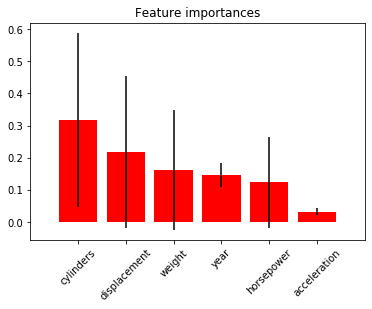

In [9]:
from sklearn.ensemble import ExtraTreesRegressor

# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)
X=df[set(independant_var) - set(['origin'])]
y=df['mpg']
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

## Train test split
Features with main importance are kept and dataset is split in training and testing sets.

In [10]:
from sklearn.model_selection import train_test_split

main_independant_var = ['cylinders', 'displacement', 'weight', 'year', 'horsepower']

X_train, X_test, y_train, y_test = train_test_split(
    df[main_independant_var], df['mpg'], test_size=0.5, random_state=42)

## Grid search to optimize hyper parameters
Since SVR algorithm, hyperparameter tuning is required. This can be easly achieved thanks to grid search, which will run through all the combination of the hyper parameter and keep the best one. 

In [11]:
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn import pipeline
from sklearn.model_selection import GridSearchCV

pipe = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()),
                          ('model', SVR())
                         ])
parameters = {'model__kernel':('linear', 'poly', 'rbf'), 'model__C':[1, 10, 100], 'model__degree':[1, 2, 3]}
grid = GridSearchCV(pipe, parameters)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'model__C': 10, 'model__degree': 1, 'model__kernel': 'rbf'}


## Best model
Model with best hyper parameter combination is fitted and analysed

In [12]:
pipe = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()),
                          ('model', SVR(kernel='rbf', C=10))
                         ])

In [13]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
print(
    'training scores\nmse={:.2f}\nr2={:.2f}\n'.\
    format(mean_squared_error(pipe.predict(X_train), y_train),
           r2_score(pipe.predict(X_train), y_train)
          )
)

print(
    'testing scores\nmse={:.2f}\nr2={:.2f}\n'.\
    format(mean_squared_error(pipe.predict(X_test), y_test),
           r2_score(pipe.predict(X_test), y_test)
          )
)

training scores
mse=6.23
r2=0.89

testing scores
mse=8.69
r2=0.83



In [15]:
df_tmp = pd.DataFrame()
df_tmp['pred'] = pipe.predict(X_test)
df_tmp['mpg'] = y_test.values
df_tmp['delta'] = df_tmp['pred'] - df_tmp['mpg']
for param in X_test.columns.values:
    df_tmp[param] = X_test[param].values

In [16]:
df_tmp[['pred', 'mpg', 'delta']].describe()

,pred,mpg,delta
count,196.000000,196.000000,196.000000
mean,23.855152,23.278571,0.576581
std,7.212646,7.512284,2.898287
min,11.247298,10.000000,-14.692687
25%,18.066946,17.500000,-0.784463
50%,24.037570,22.150000,0.549855
75%,28.971510,28.000000,2.533486
max,38.756585,44.300000,8.441539


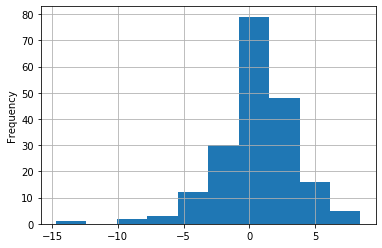

In [17]:
df_tmp['delta'].plot(kind='hist', grid=True)

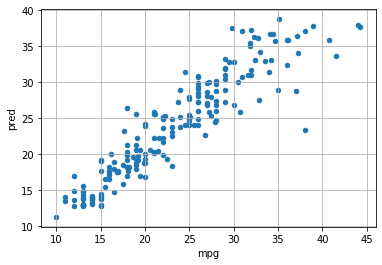

In [18]:
df_tmp.plot(kind='scatter', x='mpg', y='pred', grid=True)

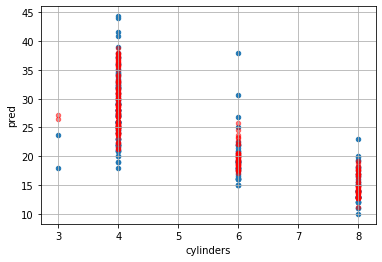

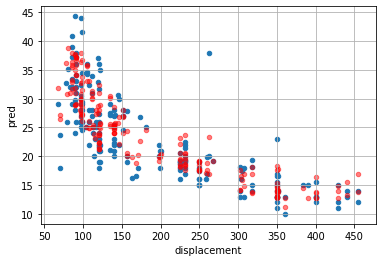

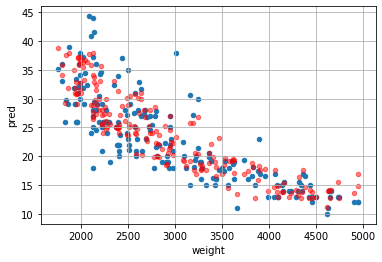

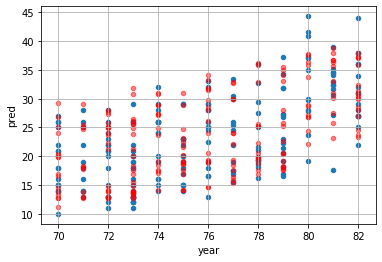

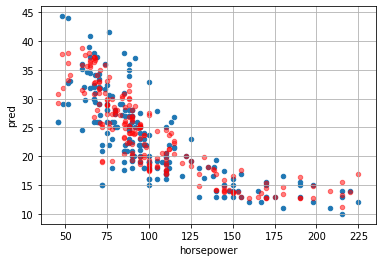

In [19]:
for param in main_independant_var:
    ax = df_tmp.plot(kind='scatter', x=param, y='mpg')
    df_tmp.plot(kind='scatter', x=param, y='pred', ax=ax, c='r', grid=True, alpha=0.5)

# Model with categorical variable
Origin parameter is a catagorical variable and shall be treated differently than a continuous variable. Instead of a scaling, it is one hot encoded into several new variables with value 0 or 1. This operation can be included inside the pipeline definition thanks to ColumnTransformer.

In [20]:
main_independant_var = ['cylinders', 'displacement', 'weight', 'year', 'horsepower', 'origin']

X_train, X_test, y_train, y_test = train_test_split(
    df[main_independant_var], df['mpg'], test_size=0.5, random_state=42)

In [21]:
from sklearn.compose import ColumnTransformer

numeric_features = ['cylinders', 'displacement', 'weight', 'year', 'horsepower']
categorical_features = ['origin']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', preprocessing.StandardScaler(), numeric_features),
        ('cat', preprocessing.OneHotEncoder(), categorical_features)])

pipe = pipeline.Pipeline([('preprocessor', preprocessor),
                          ('model', SVR(kernel='rbf', C=10))
                         ])

In [22]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['cylinders', 'displacement',
                                                   'weight', 'year',
                                                   'horsepower']),
                                                 ('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                   

In [23]:
print(
    'training scores\nmse={:.2f}\nr2={:.2f}\n'.\
    format(mean_squared_error(pipe.predict(X_train), y_train),
           r2_score(pipe.predict(X_train), y_train)
          )
)

print(
    'testing scores\nmse={:.2f}\nr2={:.2f}\n'.\
    format(mean_squared_error(pipe.predict(X_test), y_test),
           r2_score(pipe.predict(X_test), y_test)
          )
)

training scores
mse=5.78
r2=0.89

testing scores
mse=7.97
r2=0.84



In [24]:
df_tmp = pd.DataFrame()
df_tmp['pred'] = pipe.predict(X_test)
df_tmp['mpg'] = y_test.values
df_tmp['delta'] = df_tmp['pred'] - df_tmp['mpg']
for param in X_test.columns.values:
    df_tmp[param] = X_test[param].values

In [25]:
df_tmp[['pred', 'mpg', 'delta']].describe()

,pred,mpg,delta
count,196.000000,196.000000,196.000000
mean,23.625069,23.278571,0.346498
std,7.078085,7.512284,2.808342
min,11.402447,10.000000,-14.862358
25%,17.915685,17.500000,-0.890044
50%,23.939183,22.150000,0.264972
75%,28.736256,28.000000,2.000937
max,38.603549,44.300000,8.073962


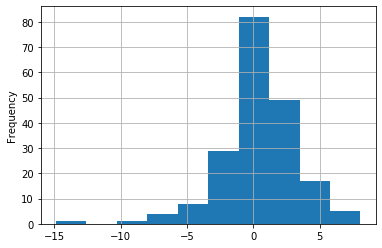

In [26]:
df_tmp['delta'].plot(kind='hist', grid=True)

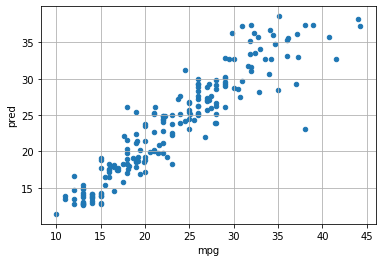

In [27]:
df_tmp.plot(kind='scatter', x='mpg', y='pred', grid=True)

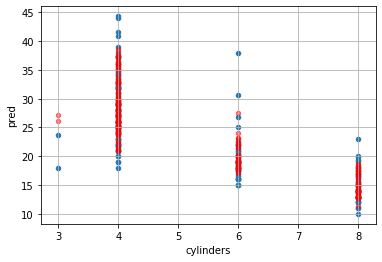

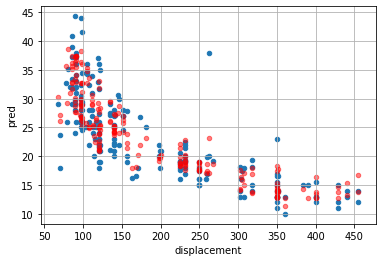

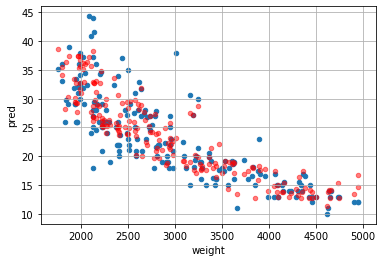

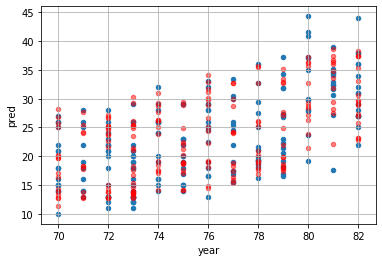

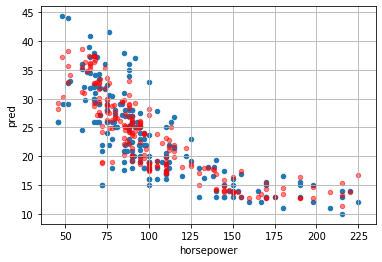

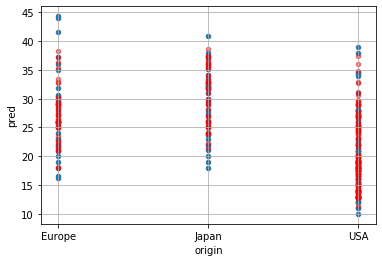

In [28]:
for param in main_independant_var:
    ax = df_tmp.plot(kind='scatter', x=param, y='mpg')
    df_tmp.plot(kind='scatter', x=param, y='pred', ax=ax, c='r', grid=True, alpha=0.5)